
# DB-GPT 智能体工作流 AWEL 设计与源码解读

## 程方银([fangyinc](https://github.com/fangyinc))

## 2024-10-29-直播材料

# DB-GPT 整个架构

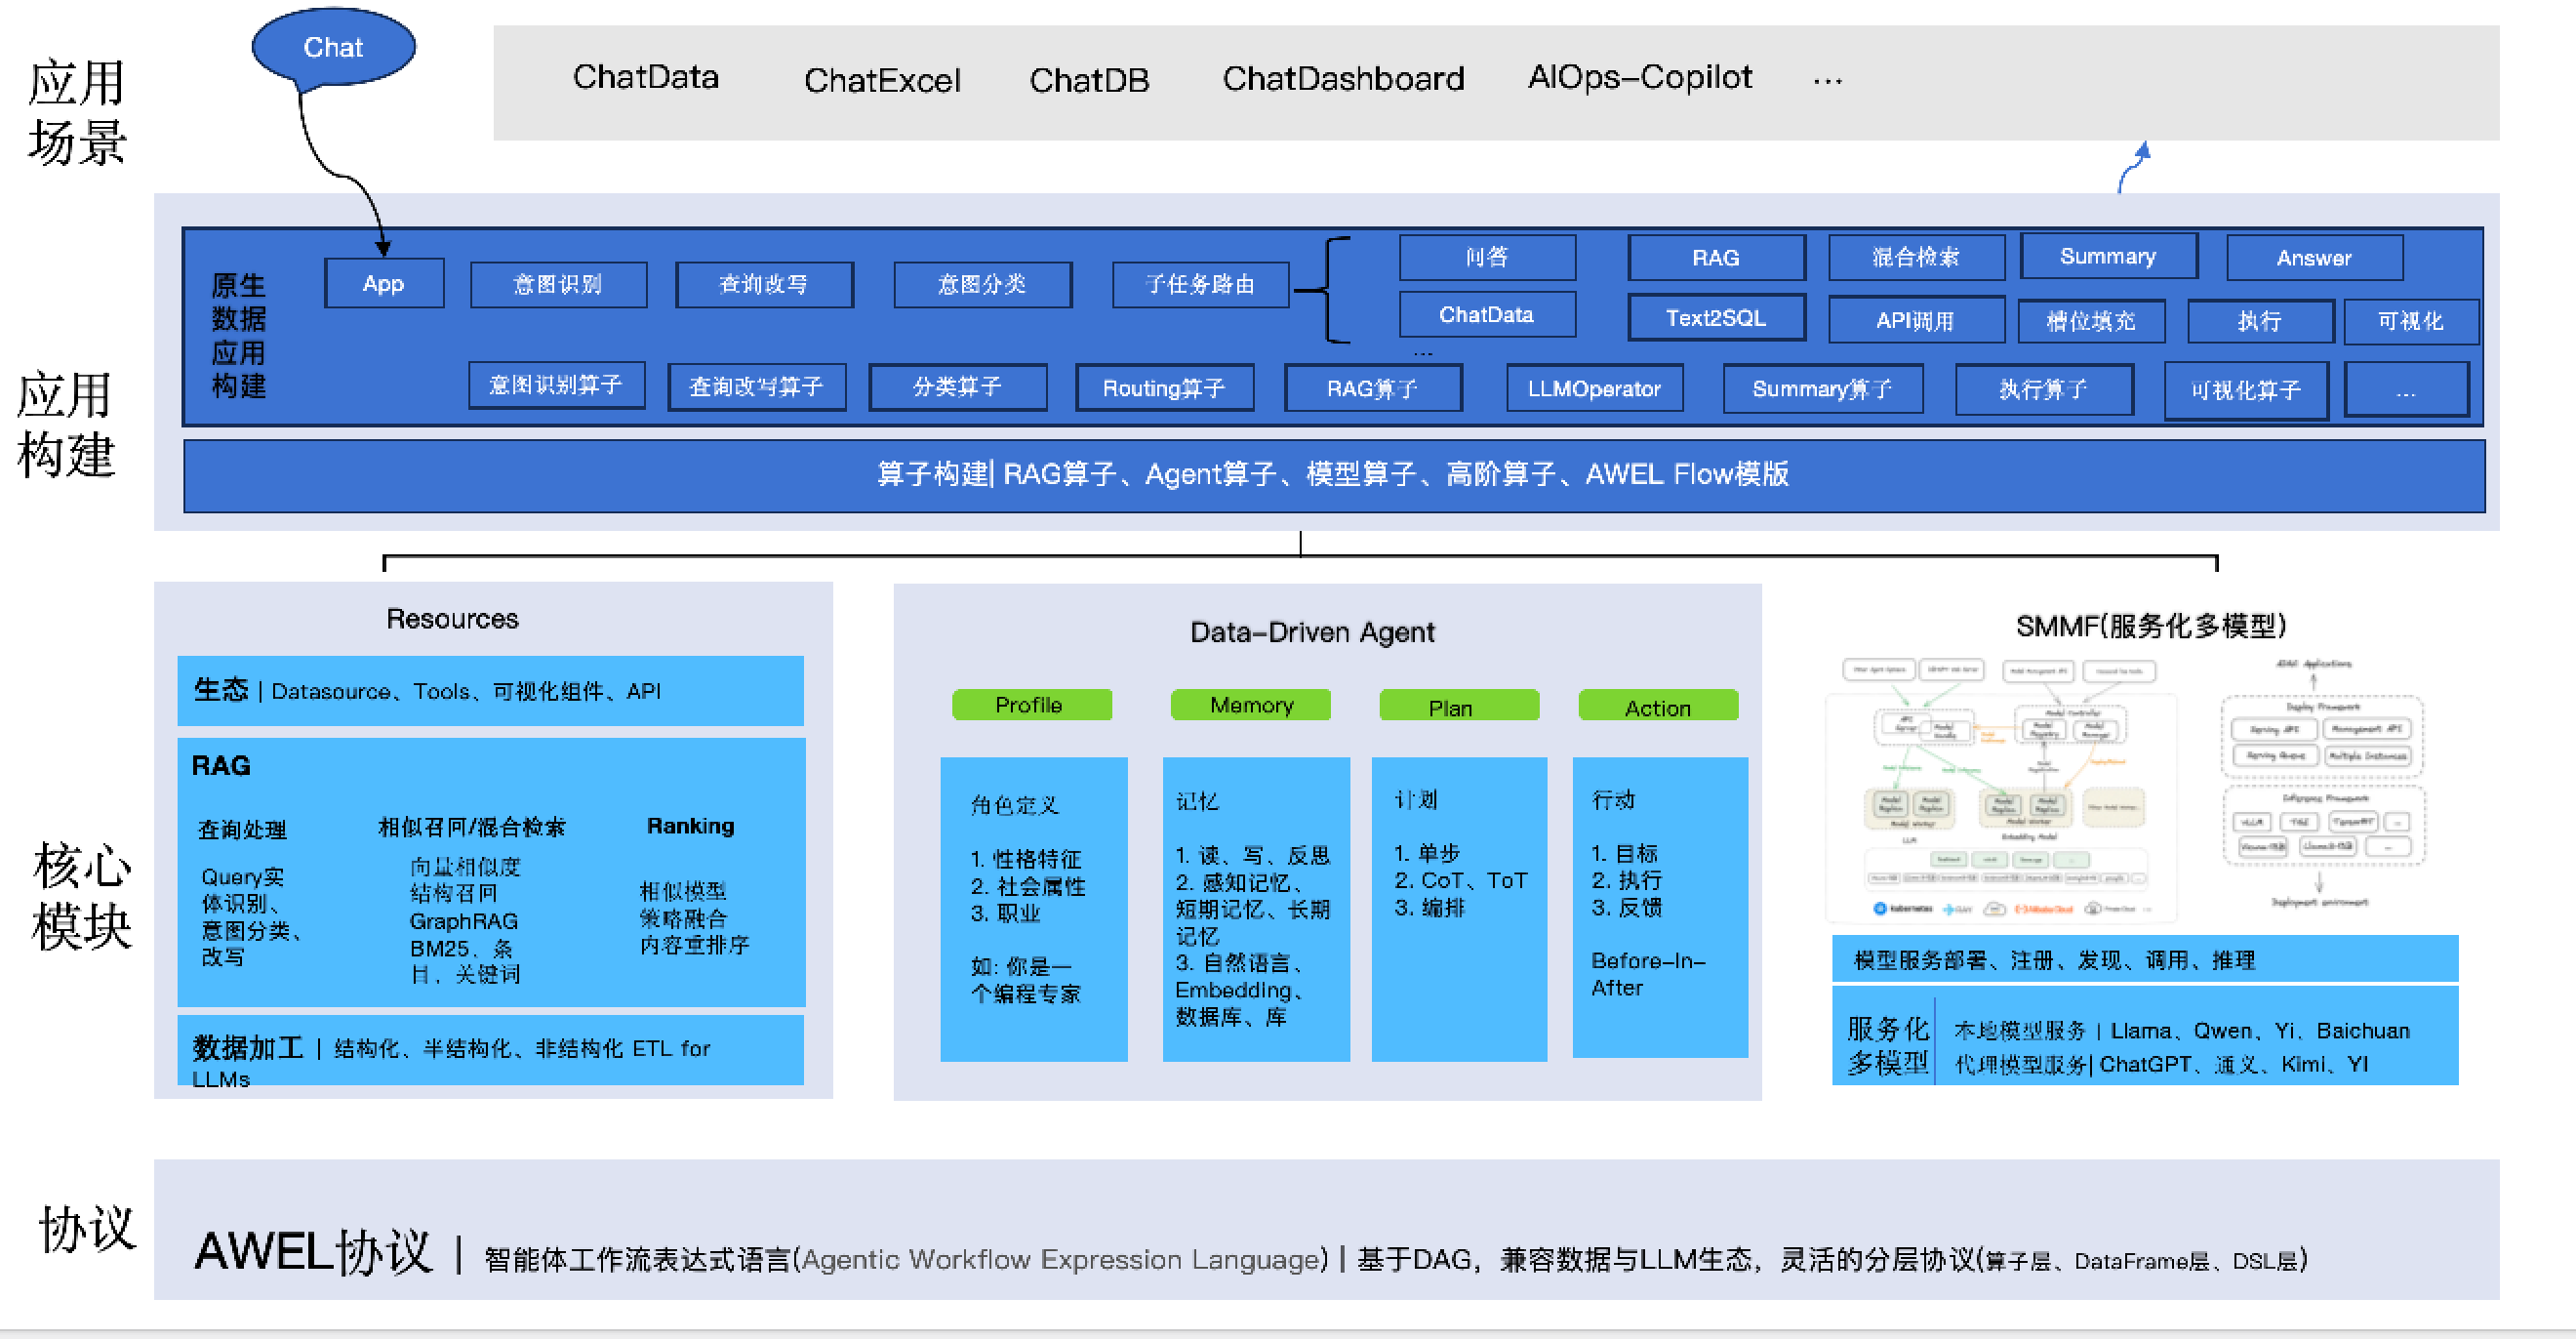

# AWEL 基础概念

## AWEL-例子-LLM 请求处理


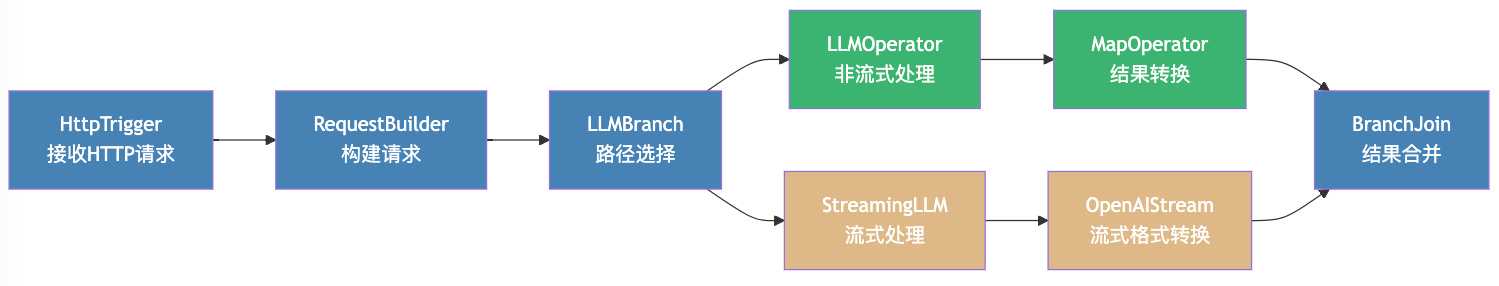



## AWEL 分层 API

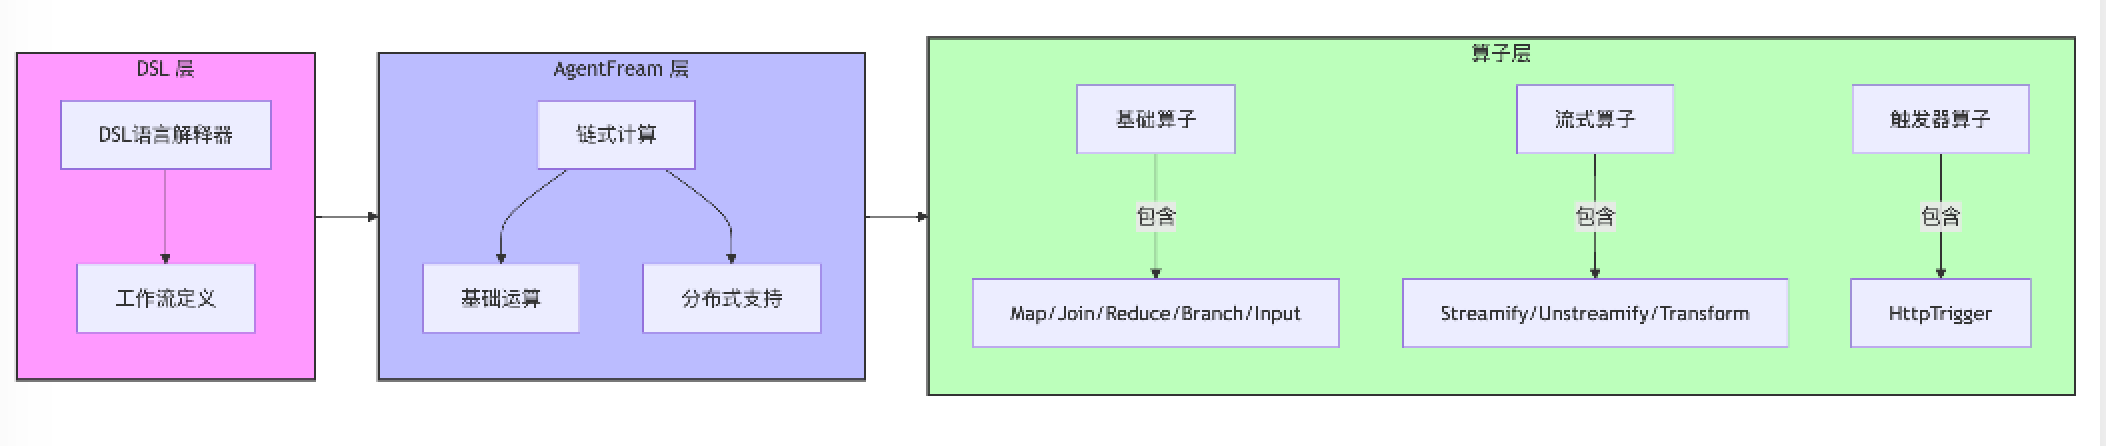


## AWEL 名词解释

### 1. DAG(Directed acyclic graph, 有向无环图)
- DAG 是用来定义任务结构和依赖关系的基本框架
- 它是一个图结构,其中的边是有方向的,并且不存在循环
- 在 AWEL 中,图的顶点是 Operator（算子）,边表示 Operator 之间的依赖关系(数据流向
- 箭头表示数据的流向

### 2. Operator(算子):  AWEL 中最基础的运行单元


### 3. Task (任务)：Operator 的实例

- 无状态设计：同一个任务可以使用不同的输入数据多次执行
- 每个 Task 可以:
    - 接收来自一个或者多个父任务输入数据
    - 向子任务输出单一数据
- 包装了输入和输出
- 提供了一些处理输入和输出的函数：map/reduce/filter/streamify/unstreamify

### 4. Runner (执行器)

- Runner 负责执行 DAG 中的任务
- 调用 `task.call()` 或者 `task.call_stream()`, Runner 会
    - 触发该任务的所有父任务
    - 执行当前任务
- 当前默认：DefaultWorkflowRunner

### 5. AWEL Flow (AWEL 可视化编排)

基于 AWEL 的**核心 API**，添加了**可视化元数据** 



### Operator 划分 

#### 1. 根据输出数据的类型来划分

**普通算子（非流式算子）：一次性返回完整的数据**
- InputOperator
- MapOperator
- BranchOperator
- JoinOperator 等

**流式算子：返回数据流**
- StreamifyAbsOperator
- TransformStreamAbsOperator

这些算子的输出是一个异步迭代器(AsyncIterator)，可以逐步产生数据



#### 2. 根据功能复杂度和抽象层次
**低阶算子**： MapOperator、InputOperator 等

**高阶算子**：多个低阶算子组合而成， `LLMOperator`, `StreamingLLMOperator` 等

In [5]:
# 导入必要包
import asyncio 
import json
from typing import *
from dbgpt.core.awel import *

# 算子的工作原理

## `MapOperator` 工作原理

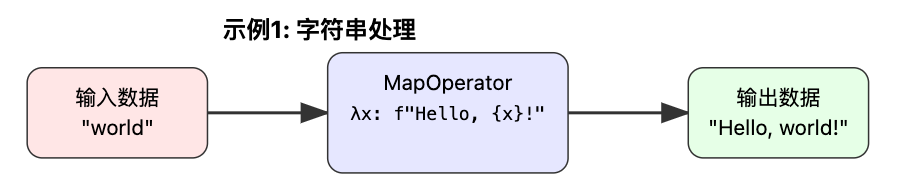

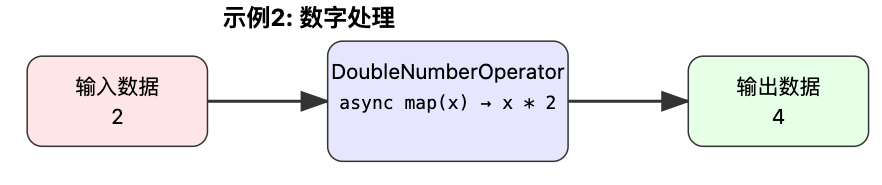

In [6]:
 with DAG("awel_hello_world") as dag:
    task = MapOperator(map_function=lambda x: f"Hello, {x}!")
    
    
class DoubleNumberOperator(MapOperator[int, int]):
    async def map(self, x: int) -> int:
        return x * 2 

with DAG("awel_double_number") as dag:
    task = DoubleNumberOperator()

## `ReduceStreamOperator` 工作原理


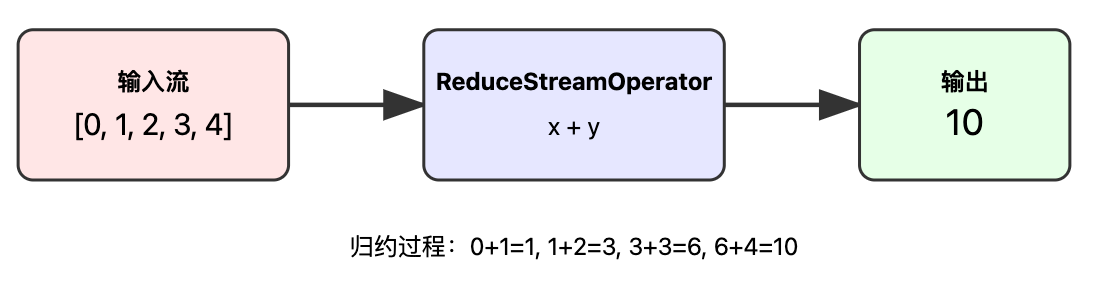


In [7]:

class NumberProducerOperator(StreamifyAbsOperator[int, int]):
    """Create a stream of numbers from 0 to `n-1`"""
    async def streamify(self, n: int) -> AsyncIterator[int]:
        for i in range(n):
            yield i

class MySumOperator(ReduceStreamOperator[int, int]):
    async def reduce(self, x: int, y: int) -> int:
        return x + y

with DAG("sum_numbers_dag") as dag:
    task = NumberProducerOperator()
    sum_task = MySumOperator()
    task >> sum_task

res = await sum_task.call(5)
res

10

## `JoinOperator 工作原理`


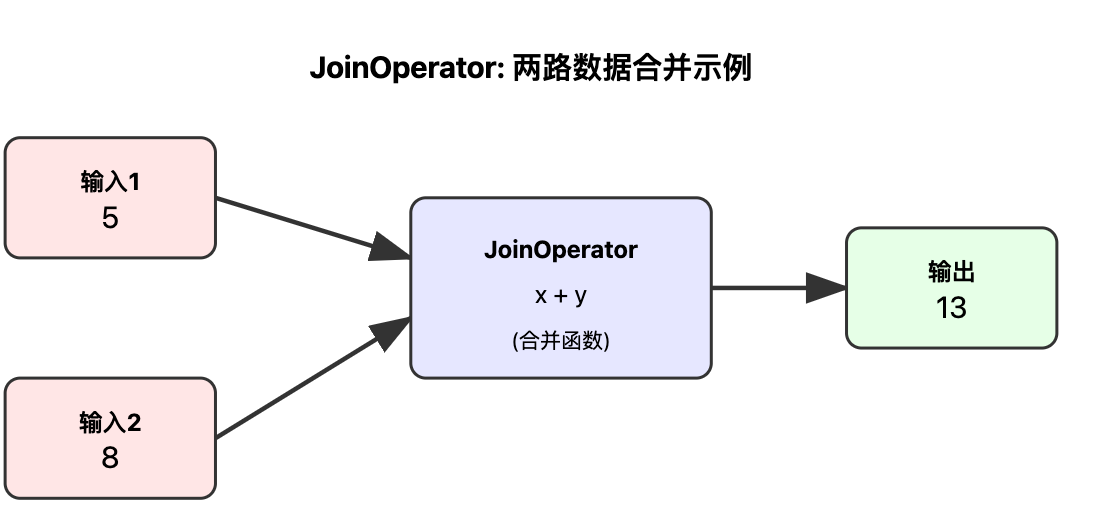

In [8]:
with DAG("sum_numbers_dag") as dag:
    # 创建输入节点
    input_task = InputOperator(input_source=SimpleCallDataInputSource())
    
    # 创建两个处理分支
    task1 = MapOperator(map_function=lambda x: x["t1"])
    task2 = MapOperator(map_function=lambda x: x["t2"])
    
    # 创建合并节点
    sum_task = JoinOperator(combine_function=lambda x, y: x + y)
    # 构建DAG
    input_task >> task1 >> sum_task
    input_task >> task2 >> sum_task
# 运行示例
result = await sum_task.call({"t1": 5, "t2": 8})  # 输出：13
result

13

## `BranchOperator` 工作原理

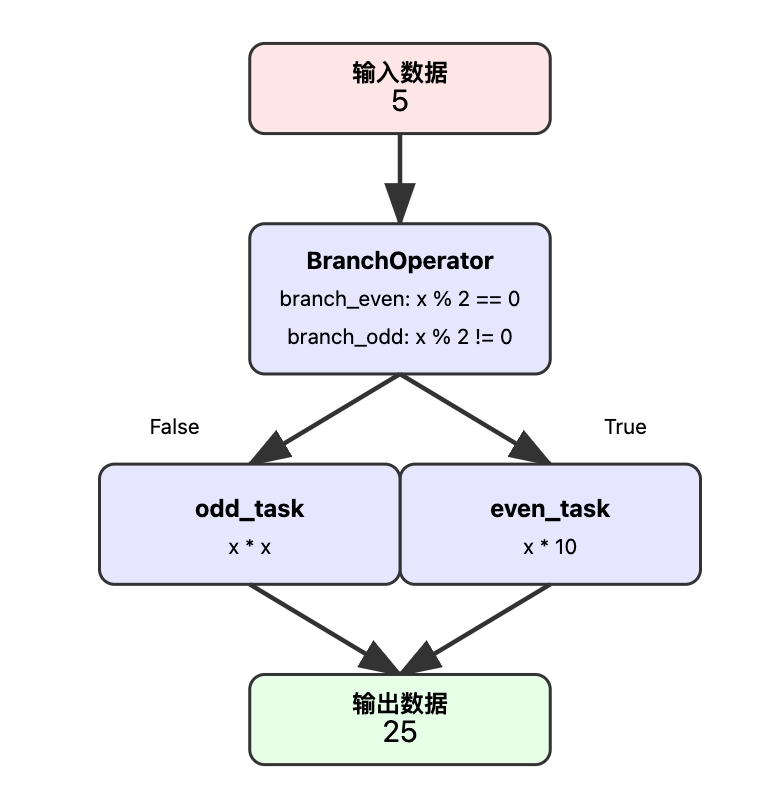

In [11]:
def branch_even(x: int) -> bool:
    return x % 2 == 0

def branch_odd(x: int) -> bool:
    return not branch_even(x)

branch_mapping = {
    branch_even: "even_task",
    branch_odd: "odd_task"
}
with DAG("awel_branch_operator") as dag:
    input_task = InputOperator(input_source=SimpleCallDataInputSource())
    task = BranchOperator(branches=branch_mapping)
    even_task = MapOperator(
        task_name="even_task", 
        map_function=lambda x: x * 10
    )
    odd_task = MapOperator(
        task_name="odd_task", 
        map_function=lambda x: x * x
    )
    join_task = JoinOperator(
        combine_function=lambda x, y: x if not is_empty_data(x) else y, can_skip_in_branch=False
    )
    input_task >> task
    task >> even_task >> join_task
    task >> odd_task >> join_task
    
res1 = await join_task.call(5)
res2 = await join_task.call(6)
print("奇数输入：", res1)
print("偶数输入：", res2)

奇数输入： 25
偶数输入： 60


## `StreamifyAbsOperator` 工作原理

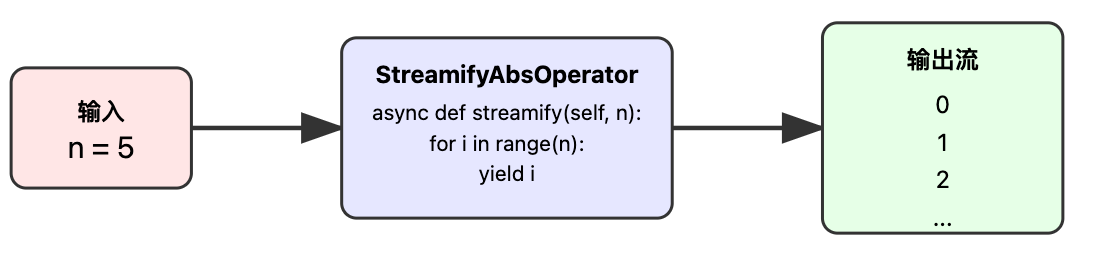


In [12]:
from typing import AsyncIterator
from dbgpt.core.awel import DAG, StreamifyAbsOperator

class NumberProducerOperator(StreamifyAbsOperator[int, int]):
    """创建从 0 到 n-1 的数字流"""
    async def streamify(self, n: int) -> AsyncIterator[int]:
        for i in range(n):
            yield i

with DAG("numbers_dag") as dag:
    task = NumberProducerOperator()
    
# 使用示例
async def print_stream(t, n: int):
    async for i in await t.call_stream(call_data=n):
        print(i)

# 输出: 0, 1, 2, 3, 4
await print_stream(task, 5)

0
1
2
3
4


In [13]:
# 模拟流式LLM服务
class MockLLMService(StreamifyAbsOperator[str, str]):
    """模拟流式LLM服务"""
    def __init__(self, mock_data: List[str], **kwargs):
        self.mock_data = mock_data
        super().__init__(**kwargs)
        
    async def streamify(self, user_input: str) -> AsyncIterator[str]:
        for data in self.mock_data:
            yield data

with DAG("mock_llm") as dag:
    # 使用示例
    task = MockLLMService(
        mock_data=["Hello, ", "how ", "can ", "I ", "help ", "you?"]
    )

async for text in await task.call_stream("Hello"):
    print(text, end="")

Hello, how can I help you?

## `UnstreamifyAbsOperator` 工作原理

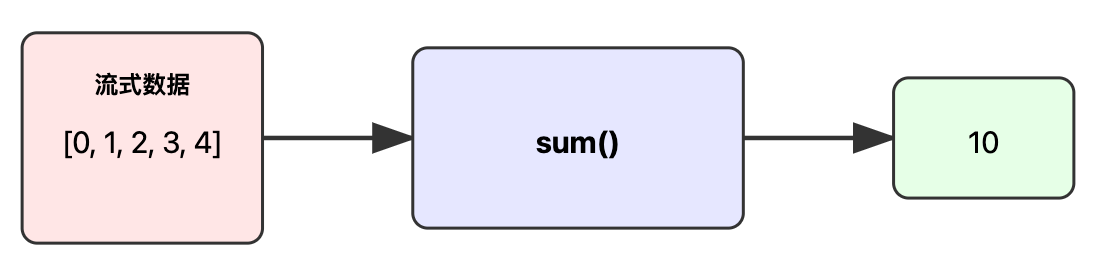

In [14]:
# 1. 先定义一个数据流生成器
class NumberProducerOperator(StreamifyAbsOperator[int, int]):
    """创建从 0 到 n-1 的数字流"""
    async def streamify(self, n: int) -> AsyncIterator[int]:
        for i in range(n):
            yield i

# 2. 定义一个流数据聚合器
class SumOperator(UnstreamifyAbsOperator[int, int]):
    """对数字流进行求和"""
    async def unstreamify(self, it: AsyncIterator[int]) -> int:
        return sum([i async for i in it])

# 3. 构建 DAG
with DAG("sum_dag") as dag:
    task = NumberProducerOperator()
    sum_task = SumOperator()
    task >> sum_task

# 4. 执行和验证
await sum_task.call(call_data=5)  # 输出：10 (0+1+2+3+4)

10

In [15]:
# LLM JSON响应处理场景
mock_data = [
    '{"na',
    'me": "Jo',
    'hn", "a',
    'ge": 2',
    '5}'
]
# 2. JSON响应处理器
class JsonResponseOperator(UnstreamifyAbsOperator[str, dict]):
    async def unstreamify(self, it: AsyncIterator[str]) -> dict:
        # 合并流式字符串
        full_response = ""
        async for chunk in it:
            # 打印流式结果
            print(chunk)
            full_response += chunk
            
        # 解析JSON
        return json.loads(full_response)
# 3. 使用示例
with DAG("json_response_dag") as dag:
    llm_task = MockLLMService(mock_data=mock_data)
    json_task = JsonResponseOperator()
    llm_task >> json_task
await json_task.call("Hello")

{"na
me": "Jo
hn", "a
ge": 2
5}


{'name': 'John', 'age': 25}

## `TransformStreamAbsOperator` 工作原理


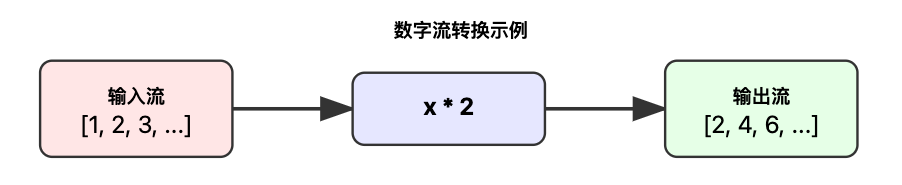


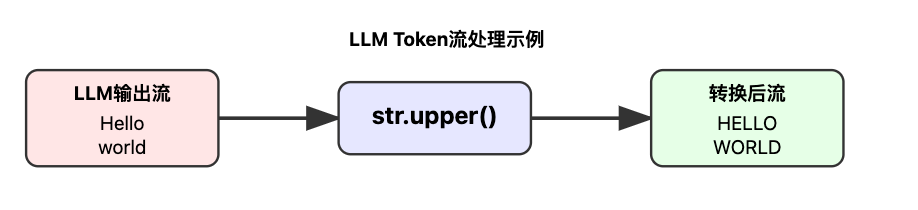

In [16]:
class NumberDoubleOperator(TransformStreamAbsOperator[int, int]):
    async def transform_stream(self, it: AsyncIterator[int]) -> AsyncIterator[int]:
        async for i in it:
            # 将每个数字翻倍
            print("原始数据：", i)
            yield i * 2
            
with DAG("num_double_dag") as dag:
    task = NumberProducerOperator()
    double_task = NumberDoubleOperator()
    task >> double_task

async for num in await double_task.call_stream(5):
    print("新数据：", num)

原始数据： 0
新数据： 0
原始数据： 1
新数据： 2
原始数据： 2
新数据： 4
原始数据： 3
新数据： 6
原始数据： 4
新数据： 8


In [17]:
# LLM 的流式文本转大写

# 模拟LLM流式输出
class MockLLMService(StreamifyAbsOperator[str, str]):
    def __init__(self, **kwargs):
        self.mock_data = ["Hello", " ", "world", "!"]
        super().__init__(**kwargs)
        
    async def streamify(self, user_input: str) -> AsyncIterator[str]:
        for token in self.mock_data:
            yield token

# 将文本转换为大写
class UpperCaseOperator(TransformStreamAbsOperator[str, str]):
    async def transform_stream(self, it: AsyncIterator[str]) -> AsyncIterator[str]:
        async for token in it:
            yield token.upper()

# 使用示例
with DAG("text_transform_dag") as dag:
    llm_task = MockLLMService()
    upper_task = UpperCaseOperator()
    llm_task >> upper_task

async for text in await upper_task.call_stream("Hi"):
    print(text, end="")

HELLO WORLD!

## `InputOperator` 工作原理

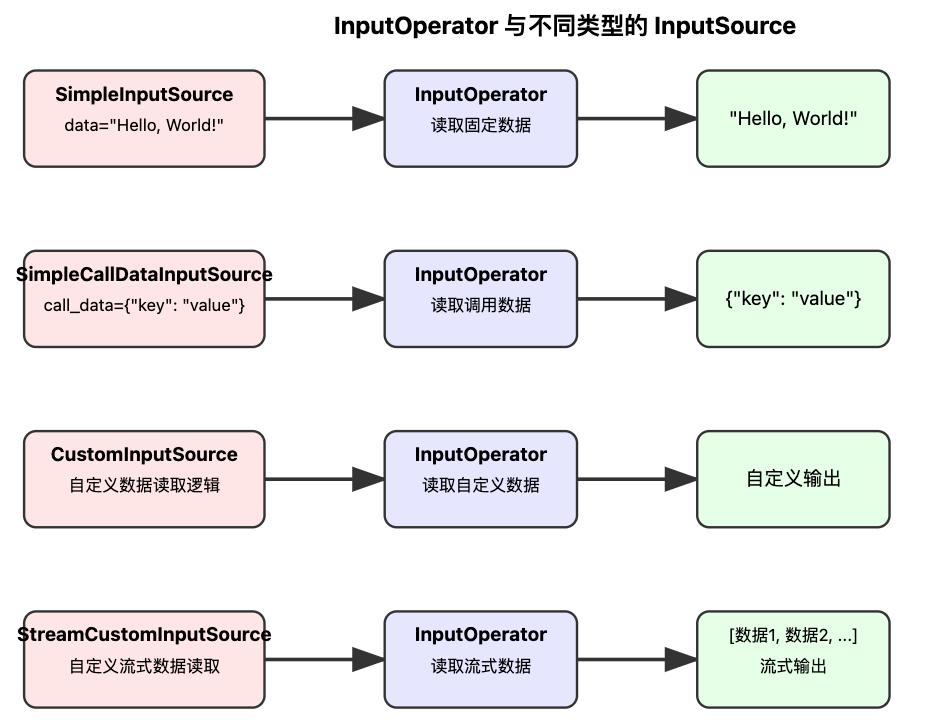


In [18]:
# 1. SimpleInputSource - 固定数据源

# 固定数据示例
with DAG("simple_input_dag") as dag:
    input_source = SimpleInputSource(data="Hello, World!")
    input_task = InputOperator(input_source=input_source)
    
    print_task = MapOperator(map_function=lambda x: print(x))
    input_task >> print_task

await print_task.call()

Hello, World!


In [19]:
# 2. SimpleCallDataInputSource - 调用时传入数据

with DAG("call_data_dag") as dag:
    input_source = SimpleCallDataInputSource()
    input_task = InputOperator(input_source=input_source)
    
    print_task = MapOperator(map_function=lambda x: print(f"Received: {x}"))
    input_task >> print_task

# 运行时传入数据
await print_task.call({"name": "John", "age": 25})

Received: {'name': 'John', 'age': 25}


In [20]:
# 3. 自定义 InputSource - 实现自定义数据读取
from dbgpt.core.awel import BaseInputSource, TaskContext
from dbgpt.core.awel.task.base import EMPTY_DATA

class MyInputSource(BaseInputSource):
    def __init__(self, prefix: str):
        self.prefix = prefix
        super().__init__()
    
    def _read_data(self, ctx: TaskContext) -> str:
        # 获取 call_data 并添加前缀
        call_data = ctx.call_data
        data = call_data.get("data", EMPTY_DATA) if call_data else EMPTY_DATA
        if is_empty_data(data):
            raise ValueError("No call data for current SimpleCallDataInputSource")
            
        return f"{self.prefix}: {data}"

# 使用自定义数据源
with DAG("custom_input_dag") as dag:
    input_source = MyInputSource(prefix="Message")
    input_task = InputOperator(input_source=input_source)
    print_task = MapOperator(map_function=lambda x: print(x))
    input_task >> print_task

# 运行
await print_task.call("Hello!")
# 输出: Message: Hello!

Message: Hello!


## `HttpTrigger` 工作原理

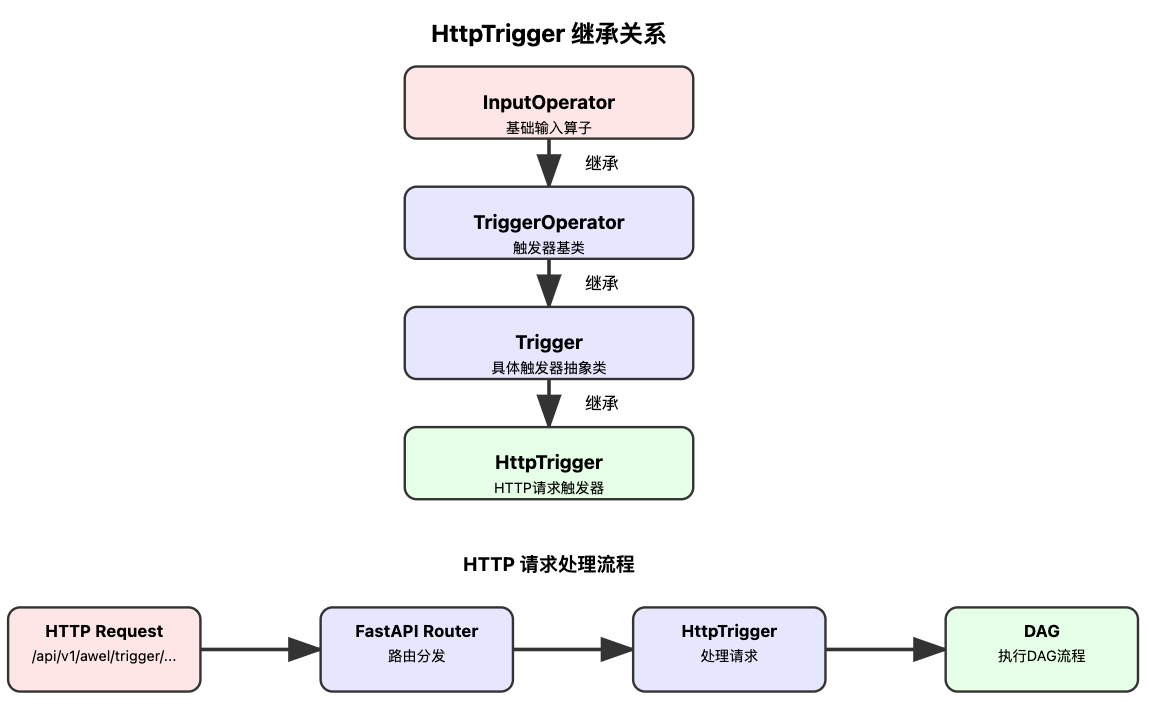

In [21]:
from dbgpt._private.pydantic import BaseModel, Field

class TriggerReqBody(BaseModel):
    name: str = Field(..., description="User name")
    age: int = Field(18, description="User age")

with DAG("awel_say_hello_post") as dag:
    trigger_task = HttpTrigger(
        endpoint="/awel_tutorial/say_hello_post", 
        methods="POST", 
        request_body=TriggerReqBody,
        status_code=200
    )
    task = MapOperator(
        map_function=lambda x: {"message": f"Hello, {x.name}! You are {x.age} years old."}
    )
    trigger_task >> task

# setup_dev_environment 方法只支持在同步环境启动
# setup_dev_environment([dag], port=5555)

# AWEL 运行原理

## Task（Operator 实例）执行流程


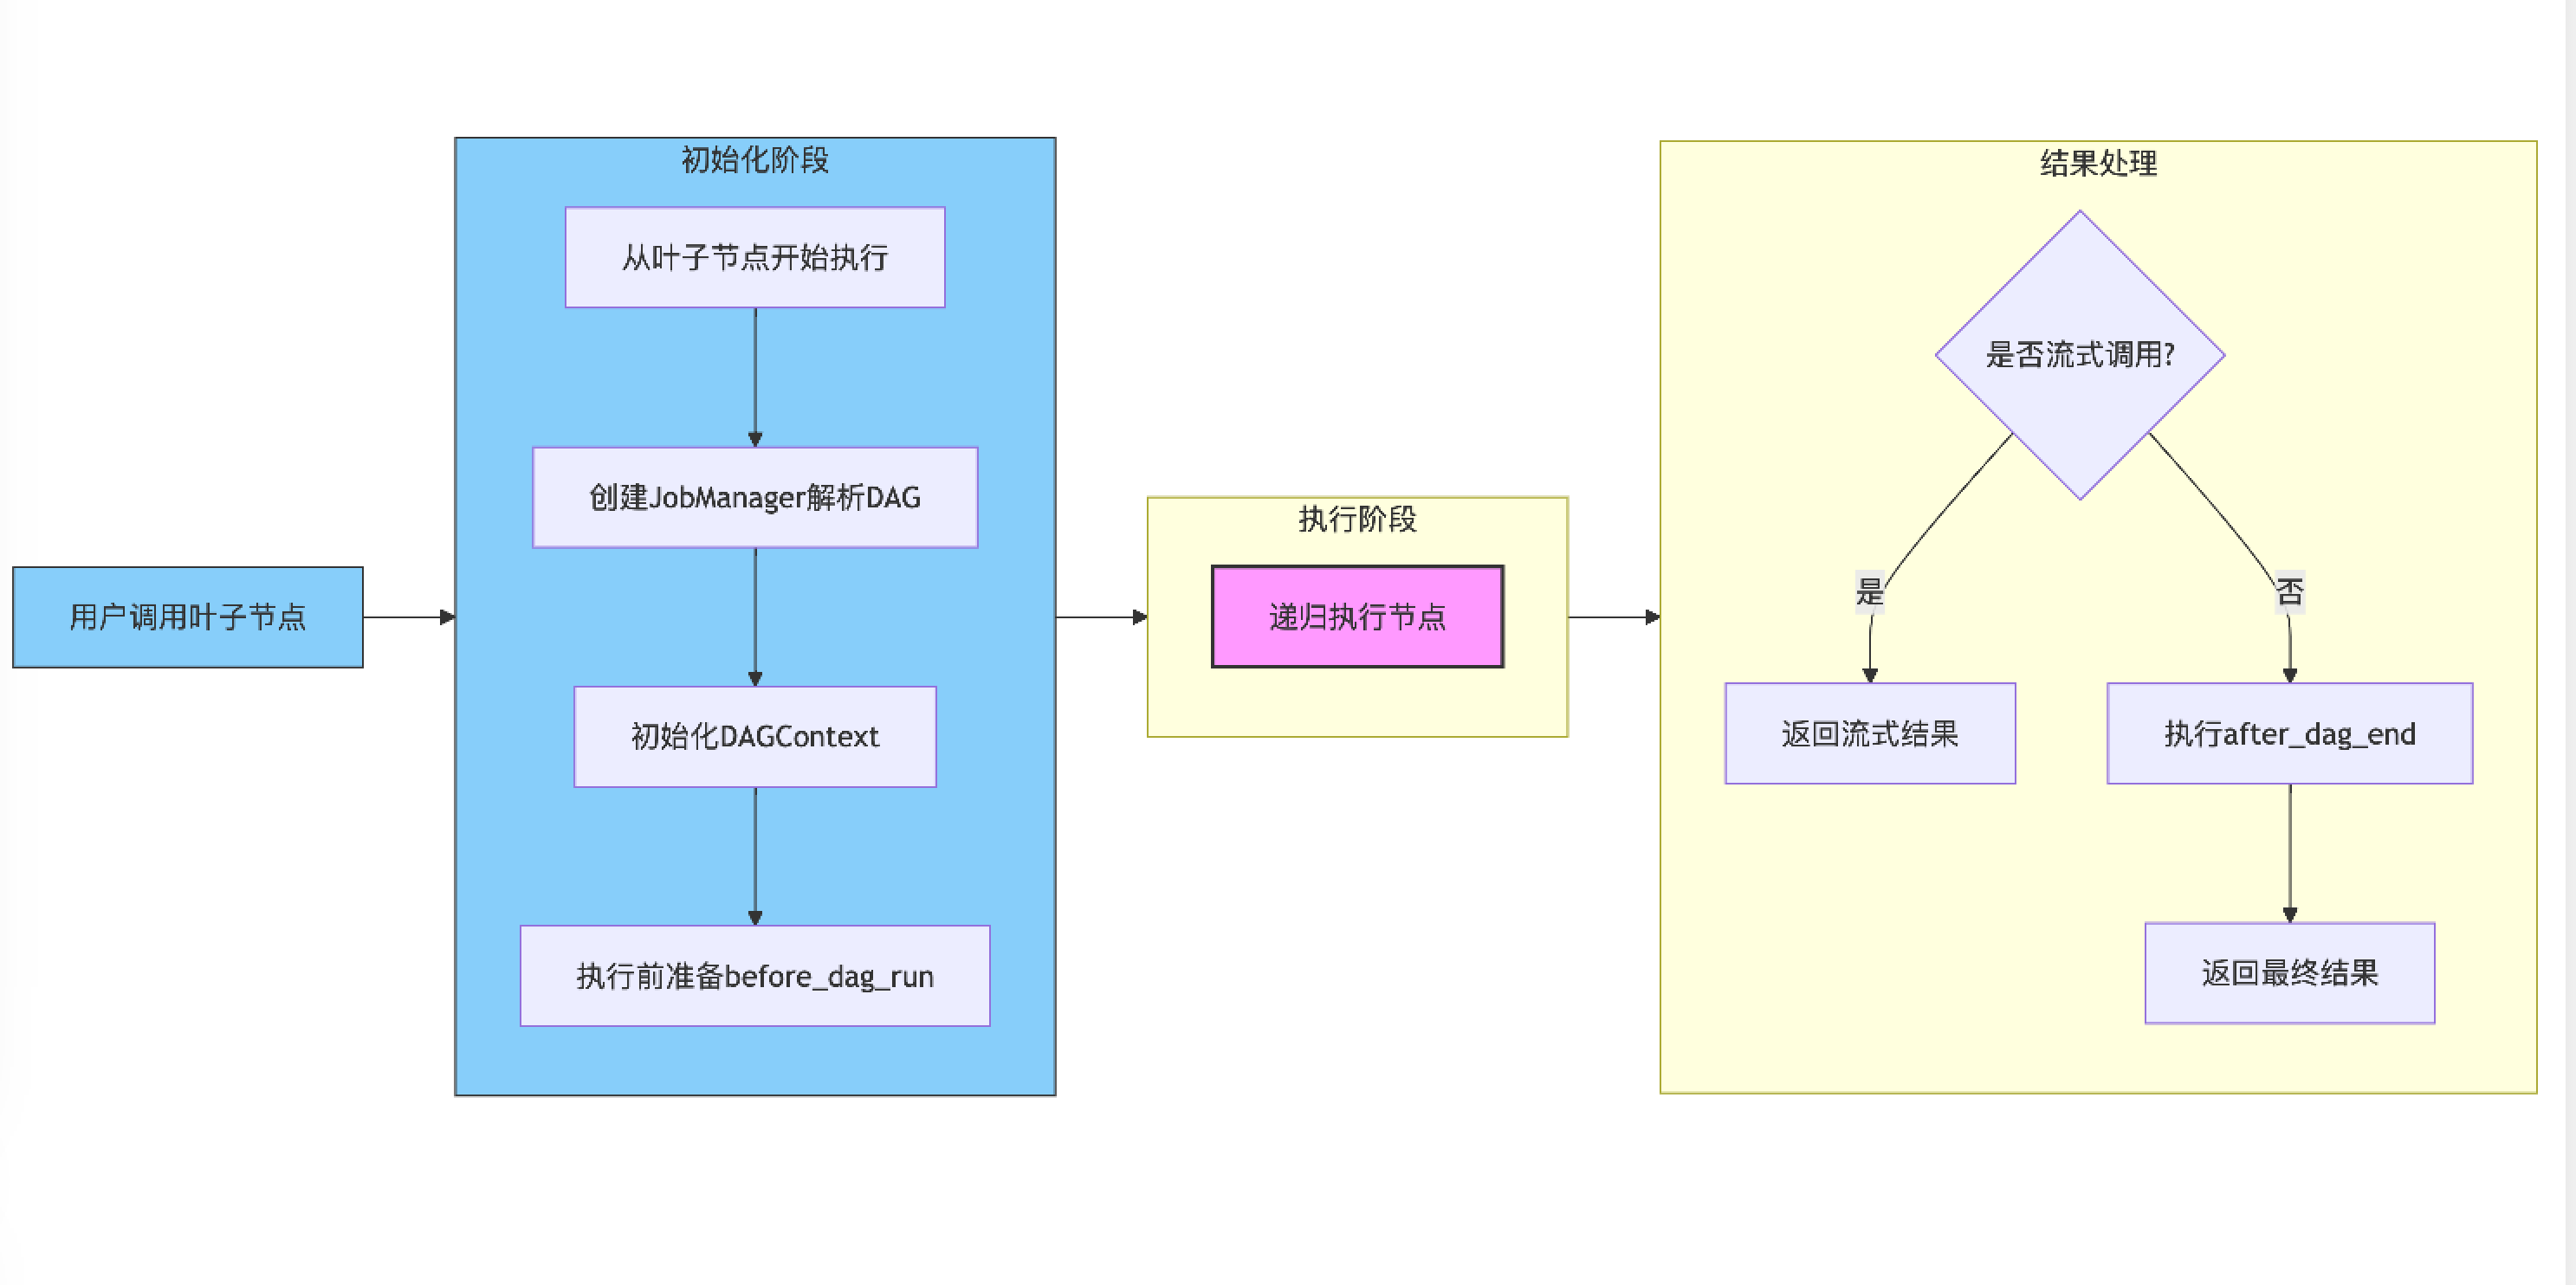



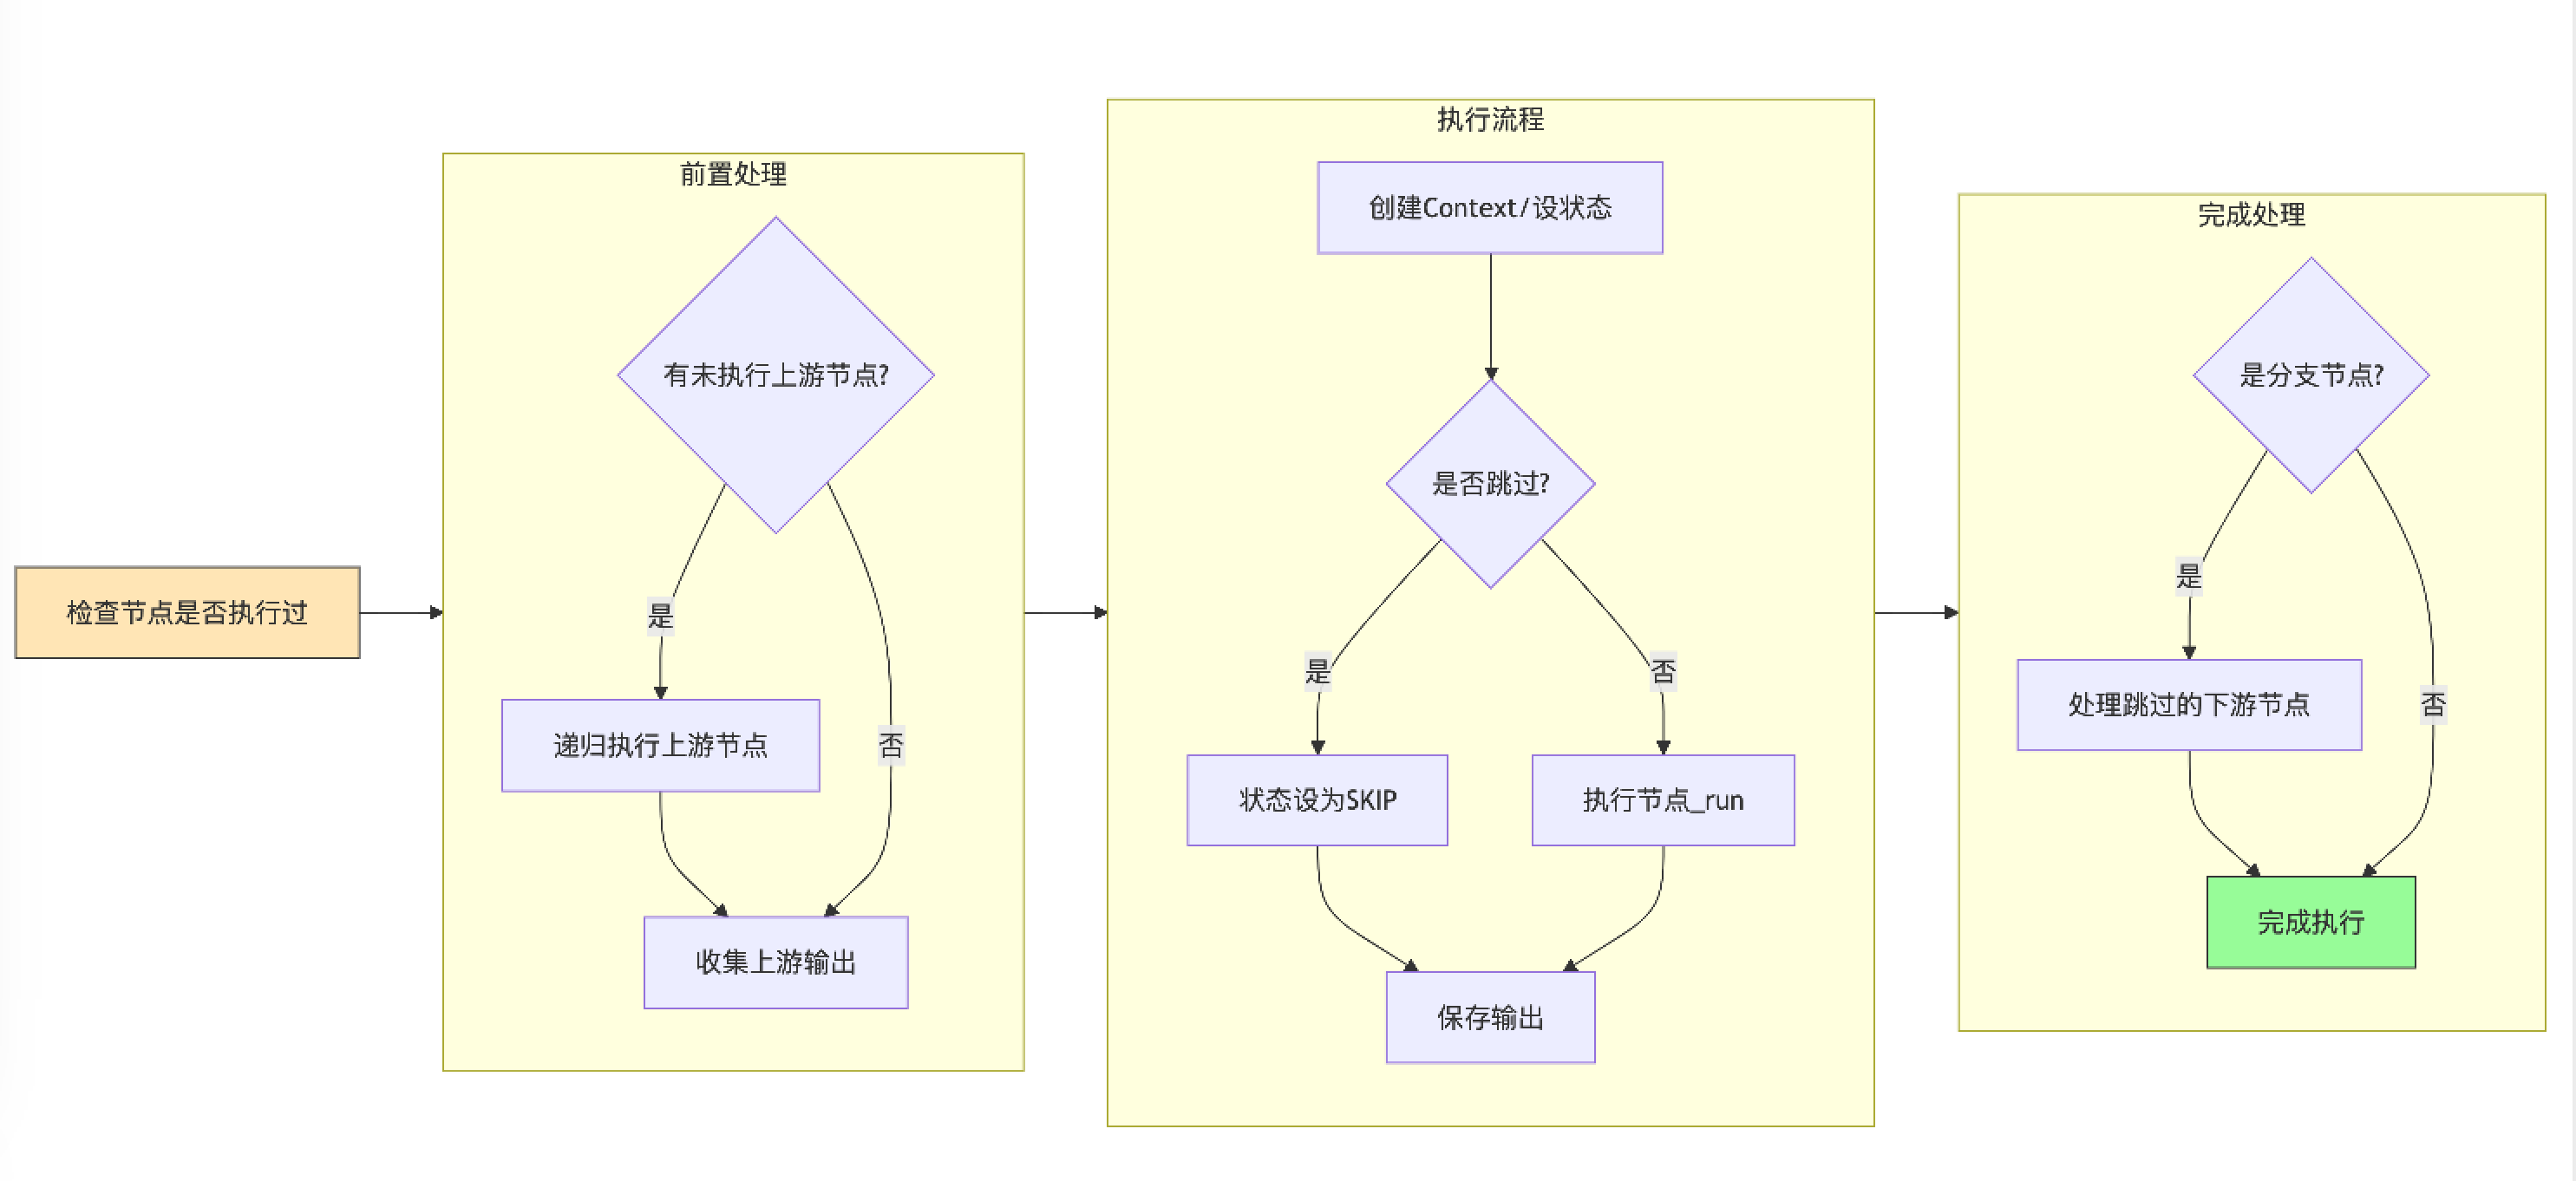

## 核心源码解读



## AWEL + Agent 案例

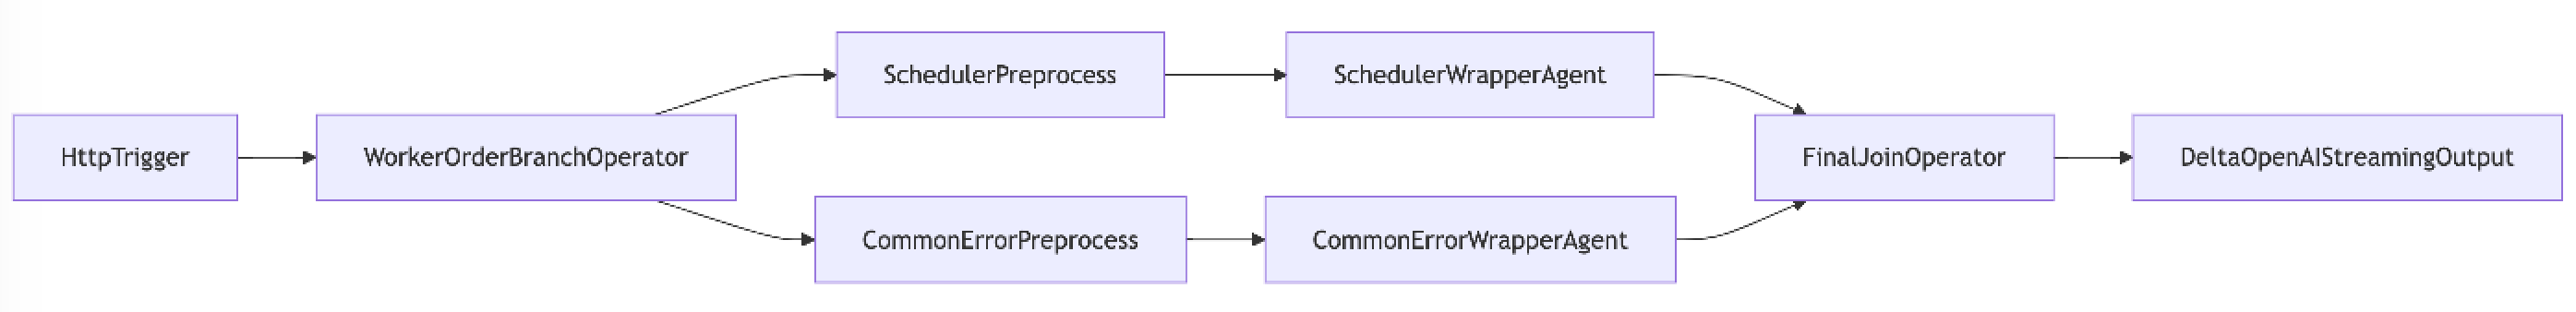

- AWEL 编排整个流程
- 流程中的某些环节交个 Agent

# 答疑

- 说明: 目前微信群太多且人数上限只有500人，问题重复且分散，不好维护，后续计划维护一个**钉钉大群**。
- 前10位提问的朋友有惊喜礼品
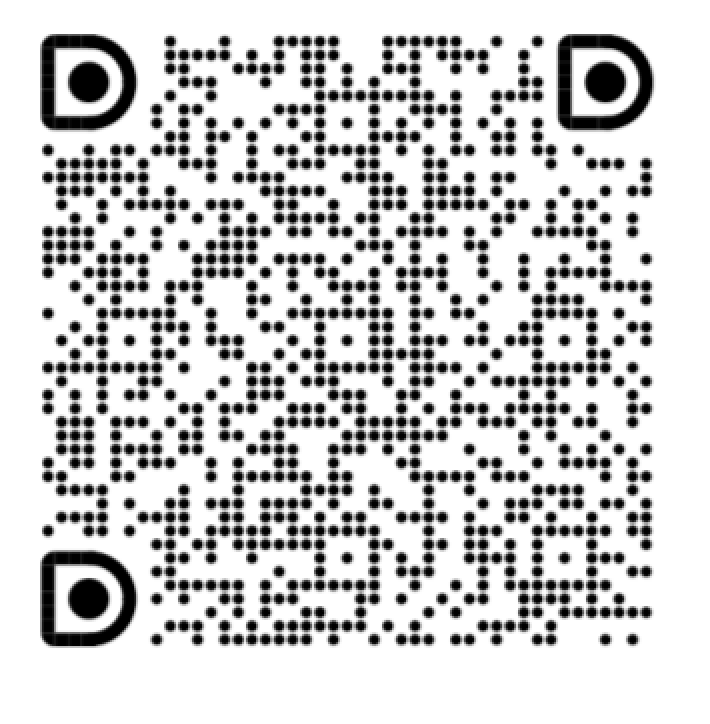